# Cosmology
Numeric Problems from homework.
Consider that this is my personal solution.

Author: ```Vicente Pedreros A.```

In [1]:
import matplotlib.pyplot as plt
import astropy.constants as const
from scipy import integrate
import numpy as np
import camb
import scienceplots

# matplotlib config
plt.style.use(['science', 'bright'])
plt.rcParams['figure.dpi'] = 300
plt.rc('font', size=16)  # fontsize for plots
plt.rc('axes', titlesize=16)  # fontsize of the title

In [2]:
# A dictionary containing cosmological parameters is created
fiducial = {'Omegam': 0.3, 'OmegaDE': 0.7, 'Omegar': 10e-4, 'hubble': 0.67, 'w0': -1, 'wa': 0}

In [3]:
# The speed of light in km / s
speed_of_light = const.c.value / 1000

# Gravitational constant in km^3/(kg s^2)
G = const.G.value * 10e-9

## P6

Using `CAMB`, plot the evolution of the density parameters for matter, radiation, dark energy and curvature.

---
*Solution*
We just need to find the density parameters, and plot them. Since the CMB is at $z\sim 1100$, it must be considered.

In [4]:
# Planck data

H0 = 67.4 # km/s/Mpc
omega_m = 0.315
omega_ch2 = 0.120
omega_bh2 = 0.0224
ns = 0.965
tau = 0.054

In [5]:
pars = camb.CAMBparams()

pars.set_cosmology(H0=H0, ombh2=omega_bh2, omch2=omega_ch2, tau=tau)


results = camb.get_results(pars)

In [6]:
def a_to_z(a):
    return 1/a - 1

a_s = np.linspace(1, 1e-4, 10_000)
zs = a_to_z(a_s)

# check if the max z is greater than 1100
zs[-1] 

9999.0

In [7]:
# dark energy
Omega_de = results.get_Omega('de', z=zs)

# matter
Omega_cdm = results.get_Omega('cdm', z=zs) # cold dark matter
Omega_b = results.get_Omega('baryon', z=zs) # baryons
Omega_mn = results.get_Omega('nu', z=zs) # massive neutrinos

Omega_m = Omega_cdm + Omega_b + Omega_mn

# radiation
Omega_ph = results.get_Omega('photon', z=zs)
Omega_n = results.get_Omega('neutrino', z=zs) # massless neutrinos

Omega_r = Omega_ph + Omega_n

# curvature
Omega_K = results.get_Omega('K', z=zs)

# total
Omega_tot = Omega_de + Omega_m + Omega_r + Omega_K

Text(0.5, 1.0, 'Density parameters evolution')

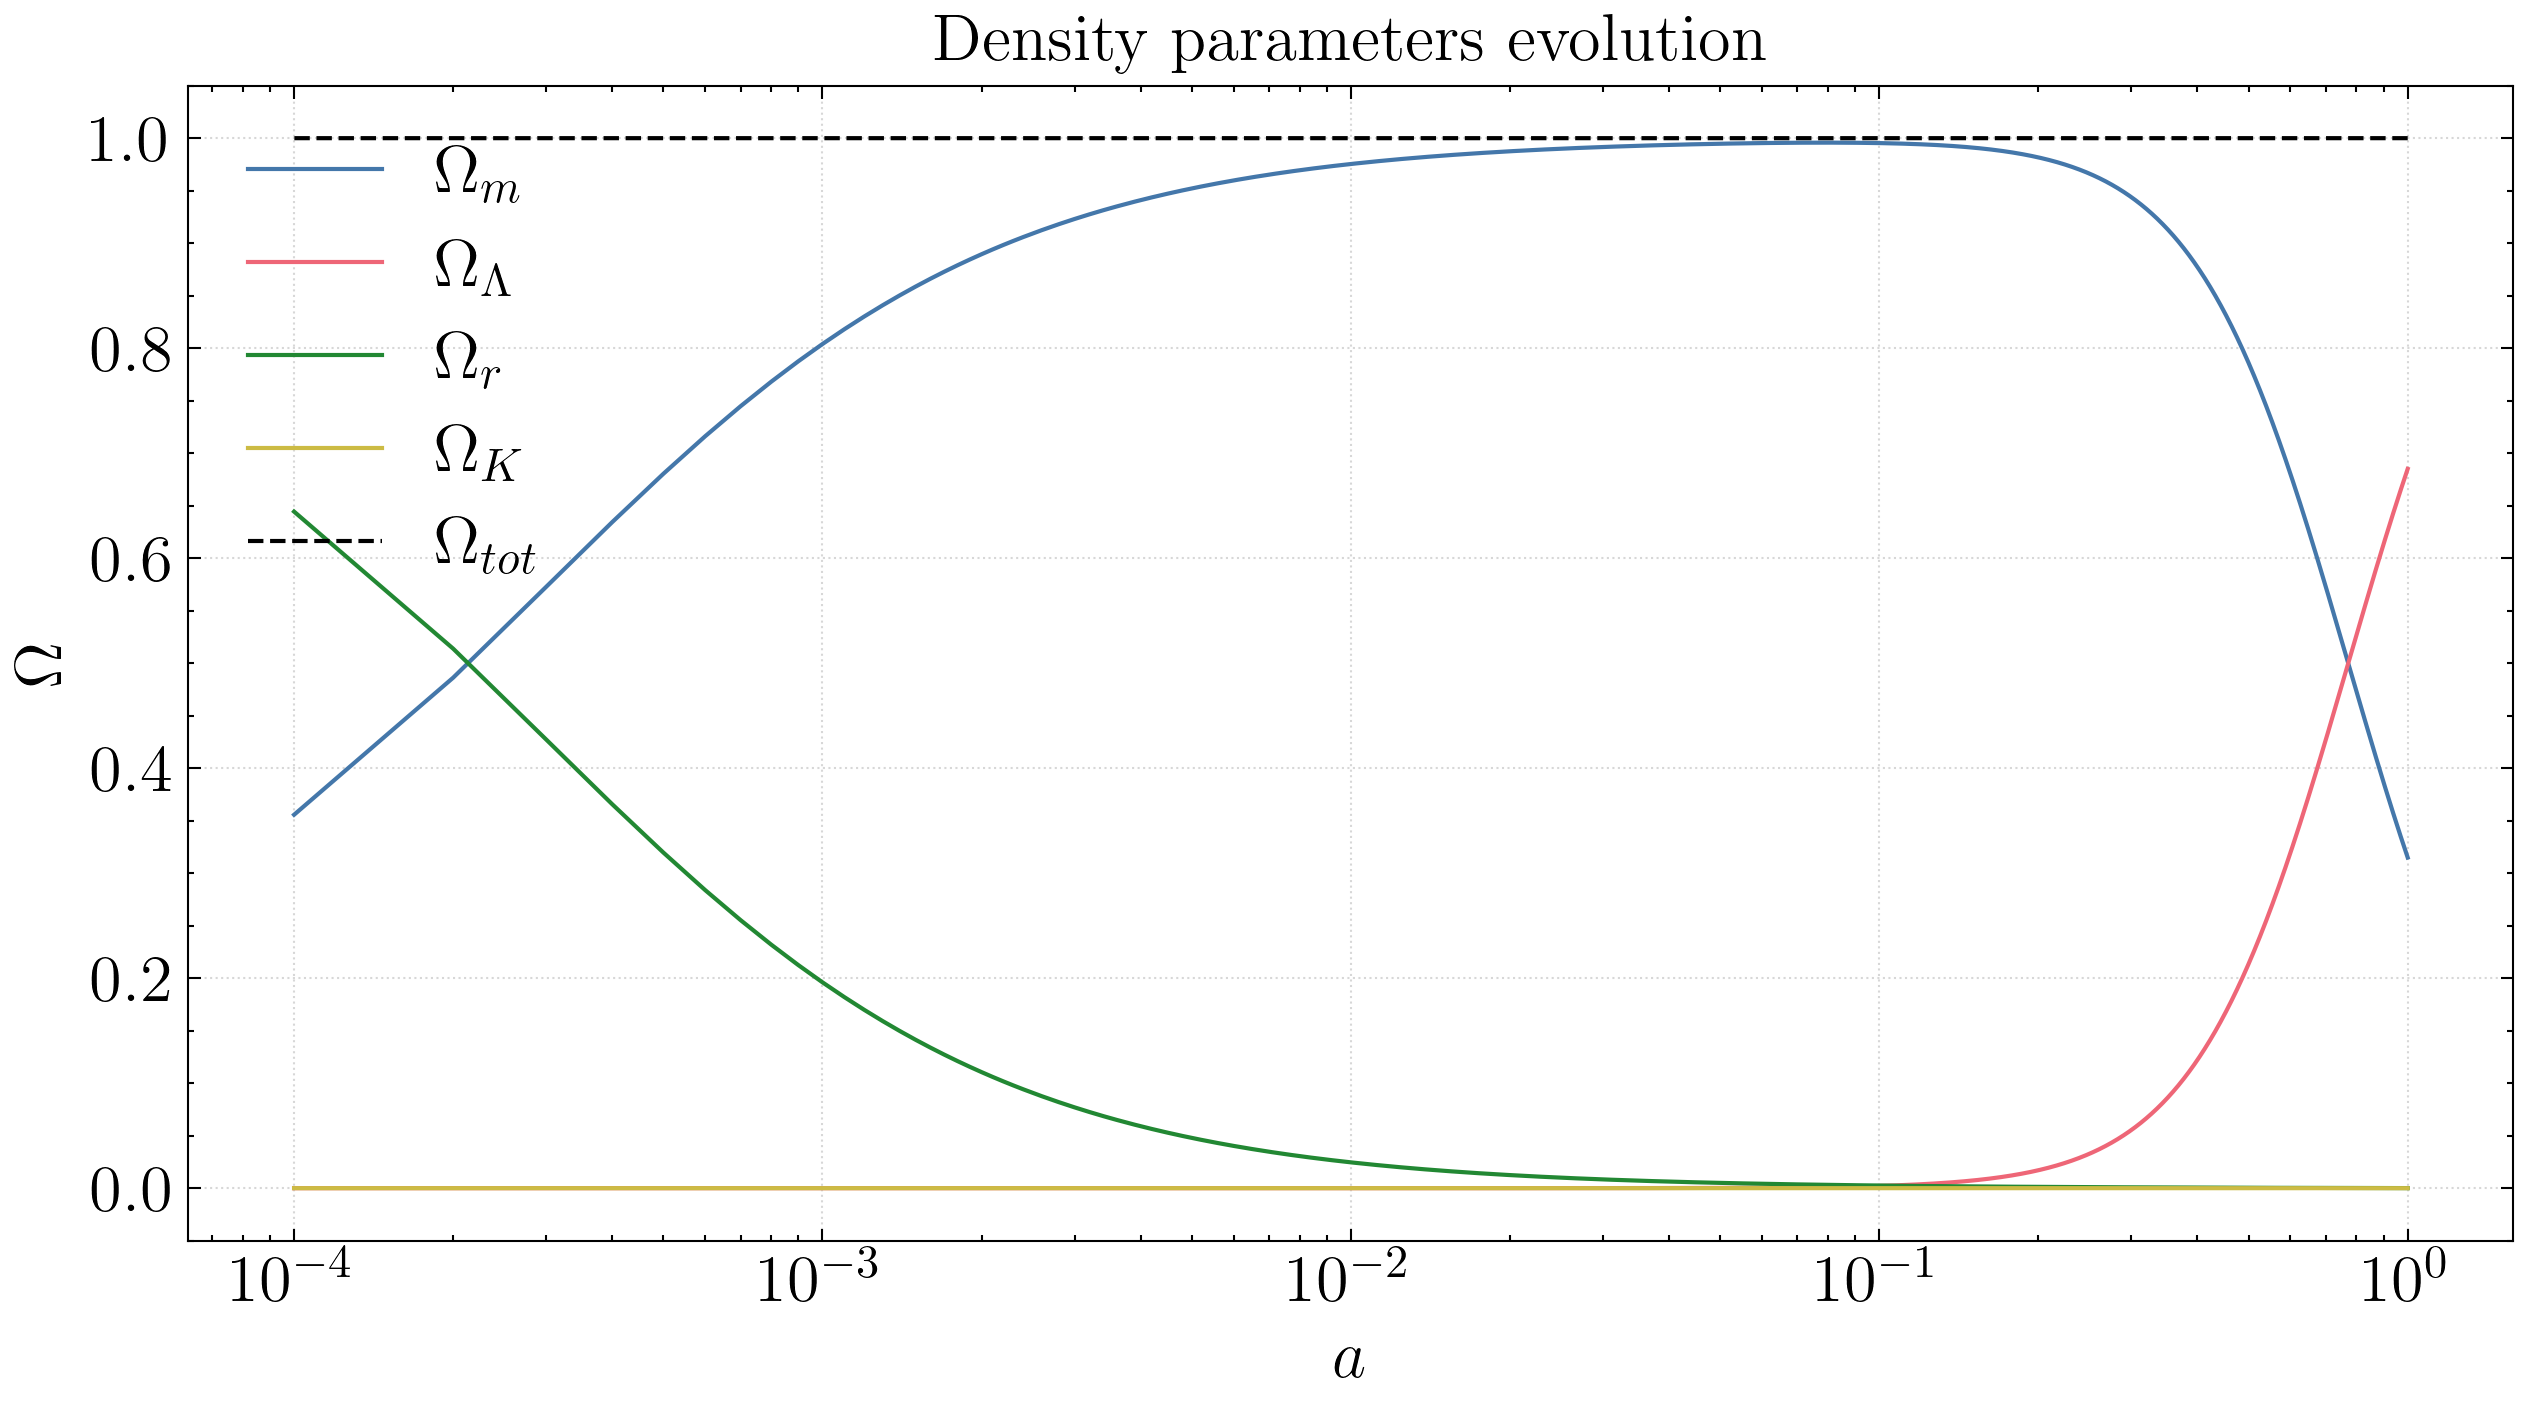

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(a_s, Omega_m, label=r'$\Omega_m$')
ax.plot(a_s, Omega_de, label=r'$\Omega_{\Lambda}$')
ax.plot(a_s, Omega_r, label=r'$\Omega_r$')
ax.plot(a_s, Omega_K, label=r'$\Omega_K$')
ax.plot(a_s, Omega_tot, color='k', ls='--', label=r'$\Omega_{tot}$')

ax.set_xscale('log')
ax.set_xlabel('$a$', fontsize=16)
ax.set_ylabel(r'$\Omega$', fontsize=16)
ax.legend(fontsize=16, loc='upper left')
ax.grid(alpha=0.5, ls=':')

ax.set_title('Density parameters evolution')

---
## P7

The distance duality relation gives
$$D_L(z)=(1+z)^2\,D_A(z)$$
where $D_L(z)$ and $D_A(z)$ are the luminosity distance and the angular diameter distance, respectively. Plot the lines of constant $f_K(\chi)$ in the plane $\Omega_{m,0}-\Omega_{\Lambda,0}$.
$$D_A(z)=\frac{1}{1+z} f_K(\chi) = \frac{1}{1+z}\frac{c}{H_0 \sqrt{\Omega_{K,0}}}\sinh{\sqrt{\Omega_{K,0}}\int_0^z}\frac{dx}{E(x)}$$
---
*Solution*

A well known parametrization for the equation of state parameter of the dark energy will be used, and is given by
$$w_{DE} = w_0 + w_a\frac{z}{1+z}$$

Since radiation is negligeble (its value is $\sim 10^{-4}$, but it is very straight forward to include it), the dimensionless Hubble parameter $E(z)$ is

$$E(z) = \sqrt{\Omega_{m,o}(1+z)^3 + \Omega_{DE,0} (1+z)^{3(1+w_0+w_a)}e^{-\frac{3w_az}{1+z}}+ \Omega_{K,0}(1+z)^2}$$

Given that we are interested on varying the density parameters for matter and dark energy, the density parameter for curvature could be negative, zero or positive, so the function $f_K$ should be redefined by cases.

$$
f_K(\chi) = \begin{cases}
    \frac{c}{H_0}\frac{1}{\sqrt{|\Omega_K|}}\sin{\left(\sqrt{|\Omega_K|} \frac{H_0}{c}\chi\right)} & \text{if } \Omega_K < 0 \\ % & is your "\tab"-like command (it's a tab alignment character)
    \chi & \text{if } \Omega_K=0 \\
    \frac{c}{H_0}\frac{1}{\sqrt{\Omega_K}}\sinh{\left(\sqrt{|\Omega_K|} \frac{H_0}{c}\chi\right)} & \text{if } \Omega_K > 0  % & is your "\tab"-like command (it's a tab alignment character)

\end{cases}
$$

In [9]:
def E(z, Omegam=fiducial['Omegam'], OmegaDE=fiducial['OmegaDE'], w0=fiducial['w0'], wa=fiducial['wa']):
    """Dimensionless Hubble parameter. Is a function of redshift and does not consider radiaton."""

    # The sum of all density parameters is one.
    OmegaK = 1 - Omegam - OmegaDE

    # Contributions matter, curvature and dark energy
    matter = Omegam * (1 + z) ** 3
    curvature = OmegaK * (1 + z) ** 2
    dark_energy = OmegaDE * (1 + z) ** (3*(1 + w0 + wa)) * np.exp(-3*wa*z/(1+z))
    
    output = np.sqrt(matter + curvature + dark_energy)
    return output

In [10]:
def comoving_dist(z, Omegam=fiducial['Omegam'], OmegaDE=fiducial['OmegaDE'], h=fiducial['hubble'], w0=fiducial['w0'], wa=fiducial['wa']):
    """Comoving distance. Function of redshift"""

    # The function that is being integrated
    integrand = lambda x: 1 / E(x, Omegam, OmegaDE, w0, wa)

    # quad integration is performed.
    integral, _ = integrate.quad(integrand, 0, z, limit=70)
    return speed_of_light * integral / (100 * h)

In [11]:
def f_K(z, Omegam=fiducial['Omegam'], OmegaDE=fiducial['OmegaDE'], h=fiducial['hubble'], w0=fiducial['w0'], wa=fiducial['wa']):
    """Function that gives us the dependance of the comoving distance for the angular diameter distance."""

    # The sum of all density parameters is one.
    OmegaK = 1 - Omegam - OmegaDE

    # Comoving distance, as previously defined.
    chi = comoving_dist(z, Omegam, OmegaDE, h, w0, wa)

    # For each case, we have a different form of the function
    if OmegaK == 0:
        output = chi
        
    elif OmegaK > 0:
        sinh = np.sinh(np.sqrt(OmegaK) * 100 * h * chi / speed_of_light)
        output = sinh * speed_of_light / (100 * h * np.sqrt(OmegaK))

    else:
        sin = np.sin(np.sqrt(np.abs(OmegaK)) * 100 * h * chi / speed_of_light)
        output = sin * speed_of_light / (100 * h * np.sqrt(np.abs(OmegaK)))
        
    return output

We look for lines of constant $f_K(\chi)$ in the plane $\Omega_{m,0}-\Omega_{\Lambda,0}$. 

In [12]:
def contour_fK(z, lvls=30, w0=fiducial['w0'], wa=fiducial['wa']):

    # The values considered for the density parameters of matter and dark energy
    Omegam_values = np.linspace(0, 3, 100)
    OmegaDE_values = np.linspace(-1, 3, 100)
    
    # Create a meshgrid for the previous values, so we can get every combination possible
    Omegam_mesh, OmegaDE_mesh = np.meshgrid(Omegam_values, OmegaDE_values)
    
    # Evaluate f_K for each combination of the density parameters.
    f_K_values = np.vectorize(f_K)(z, Omegam=Omegam_mesh, OmegaDE=OmegaDE_mesh, w0=w0, wa=wa)
    
    # Create a contour plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the line where Omegam + OmegaDE = 1, a flat universe.
    sum_values = Omegam_mesh + OmegaDE_mesh
    ax.contour(Omegam_mesh, OmegaDE_mesh, sum_values, levels=[1], colors='r')

    # Plot contour lines for constant f_K
    contour_plot = ax.contourf(Omegam_mesh, OmegaDE_mesh, f_K_values, levels=lvls)
    colorbar = fig.colorbar(contour_plot)
    colorbar.set_label('$Mpc$')
    
    # Add labels and title
    ax.set_xlabel('$\Omega_{m,0}$')
    ax.set_ylabel('$\Omega_{DE,0}$')
    ax.set_title('Contour Plot of $f_K$ at z=%i'%z)
    
    # We save the figure
    fig.savefig('counterplot_z=%i.pdf'%z)


/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/3056088390.py:12: RuntimeWarning: invalid value encountered in sqrt
  output = np.sqrt(matter + curvature + dark_energy)
/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/1277488624.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = integrate.quad(integrand, 0, z, limit=70)
/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/1277488624.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  integrand = lambda x: 1 / E(x, Omegam, OmegaDE, w0, wa)
/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/1277488624.py:8: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  integral, _ = integrate.quad(integrand, 0, z, limit=70)


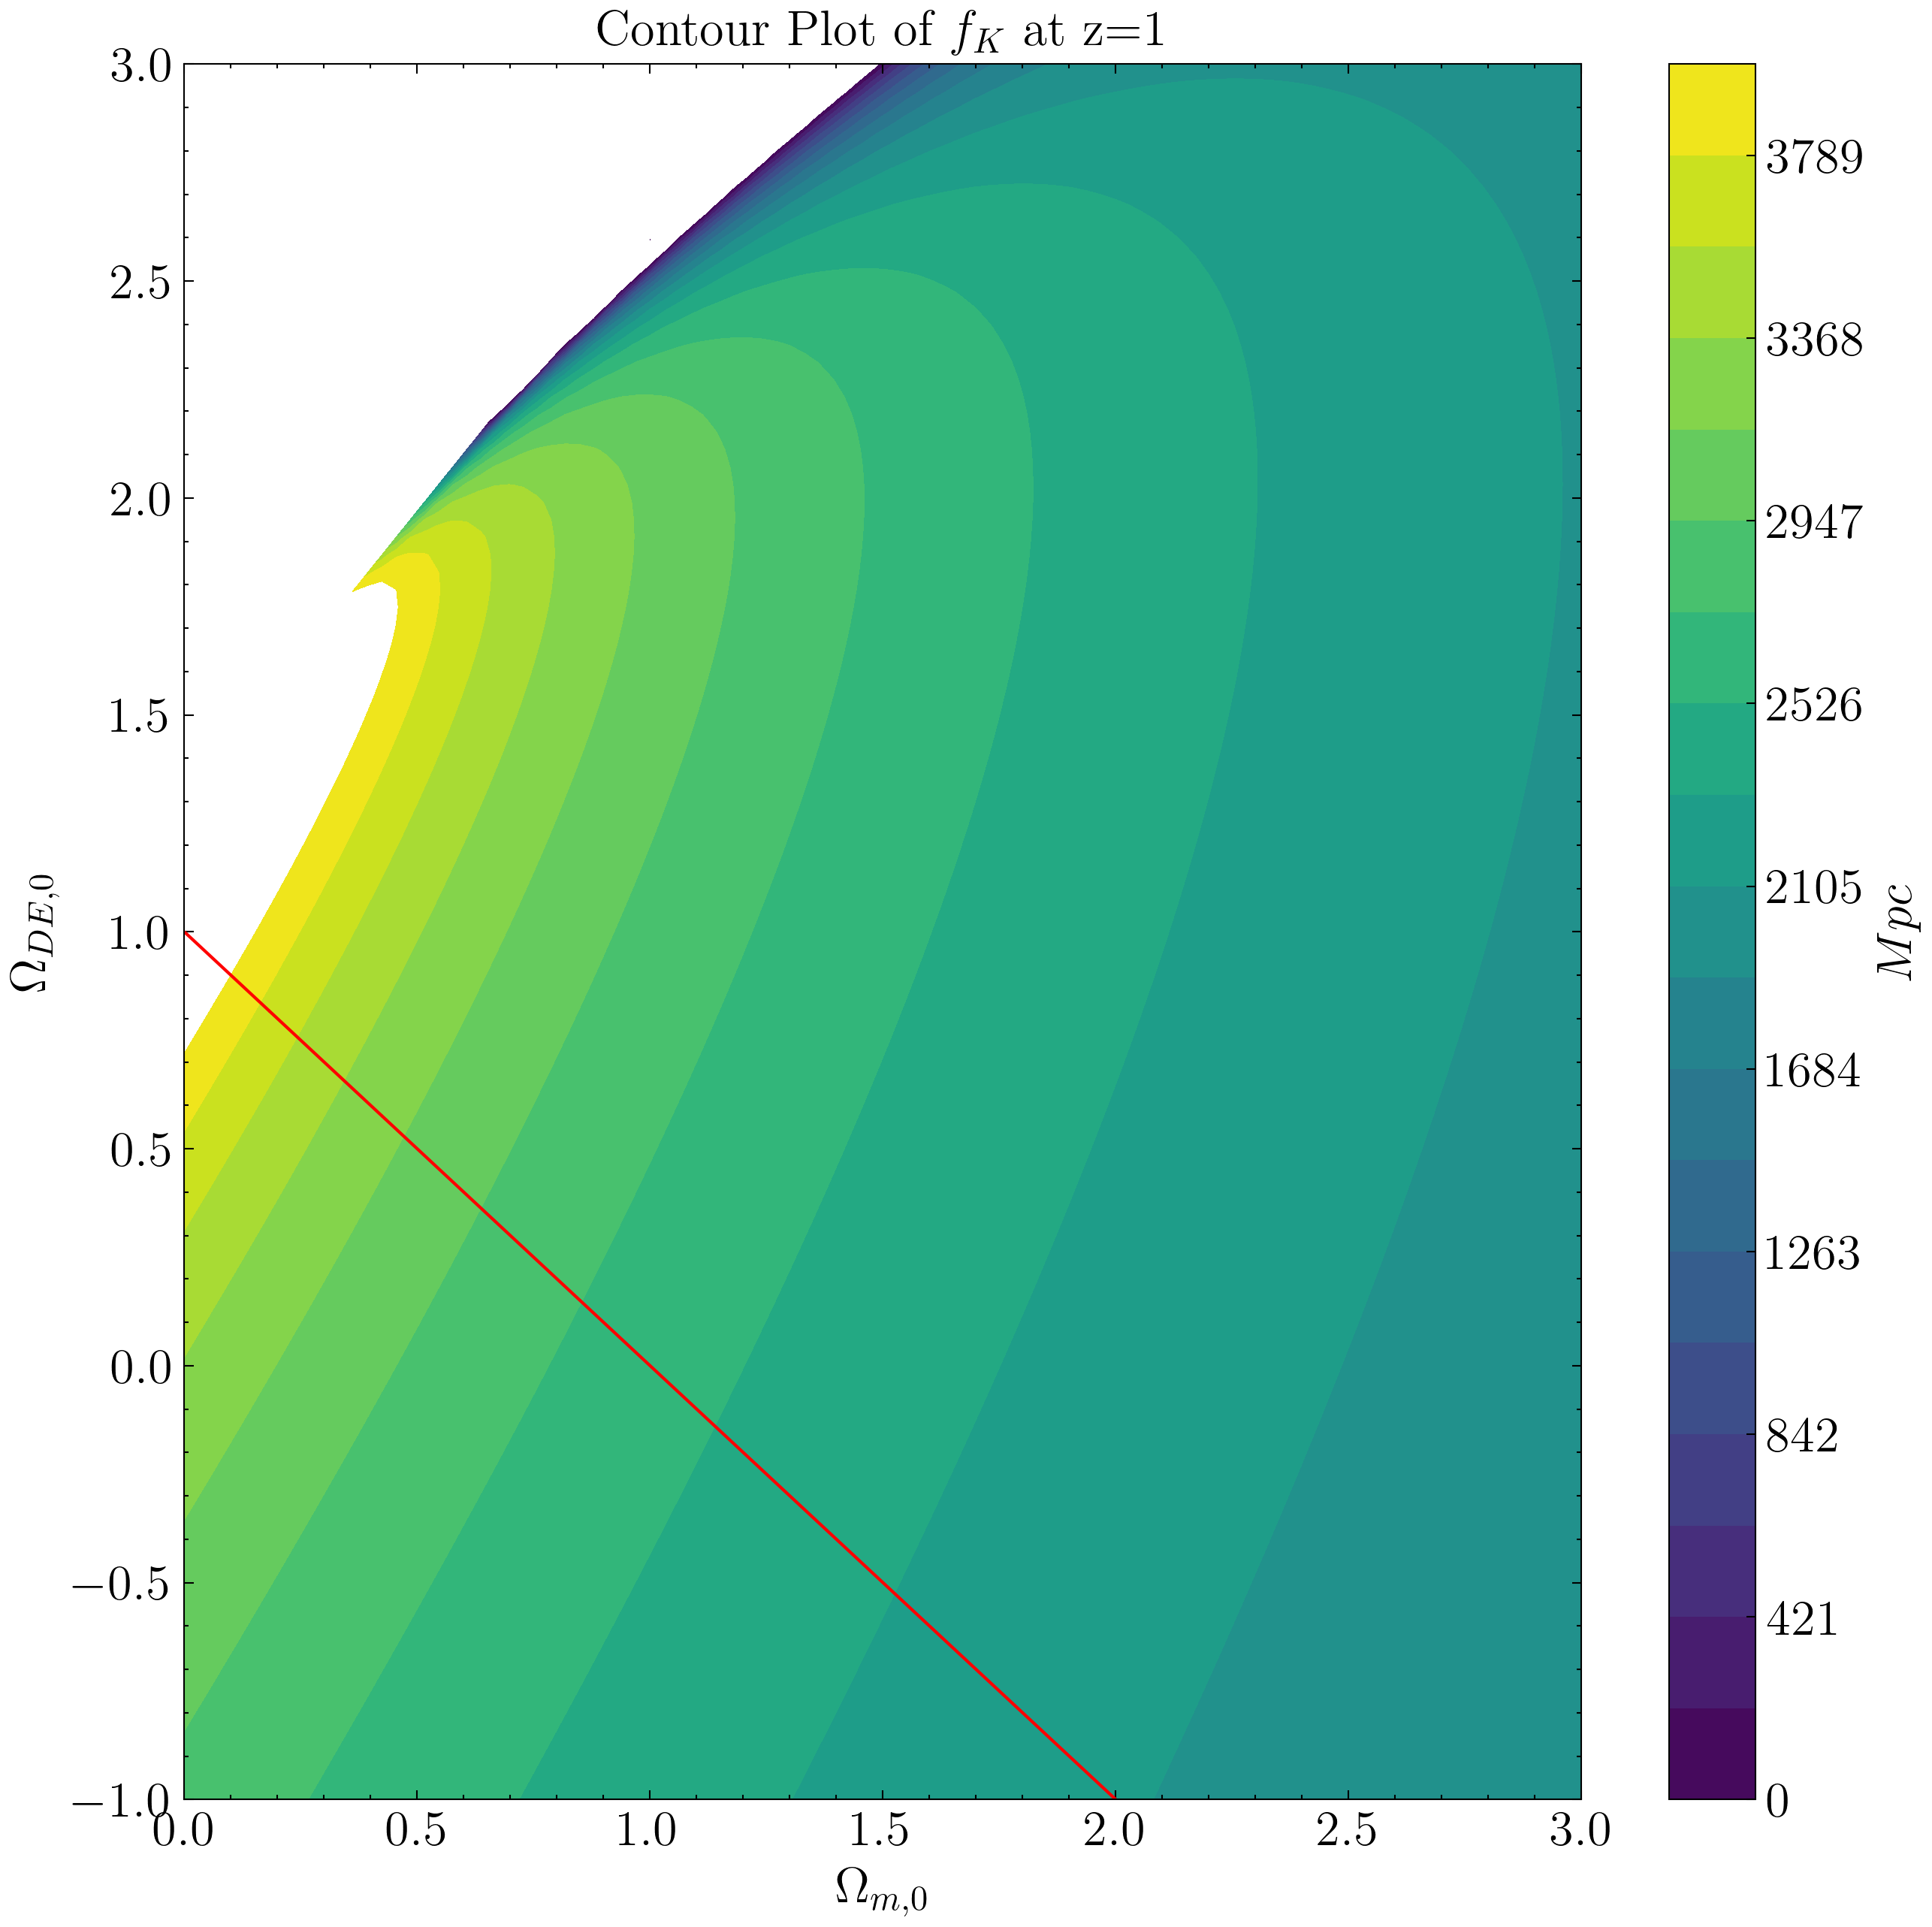

In [13]:
contour_fK(1, lvls=np.linspace(0, 4000, 20))

/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/3056088390.py:12: RuntimeWarning: invalid value encountered in sqrt
  output = np.sqrt(matter + curvature + dark_energy)
/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/1277488624.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = integrate.quad(integrand, 0, z, limit=70)


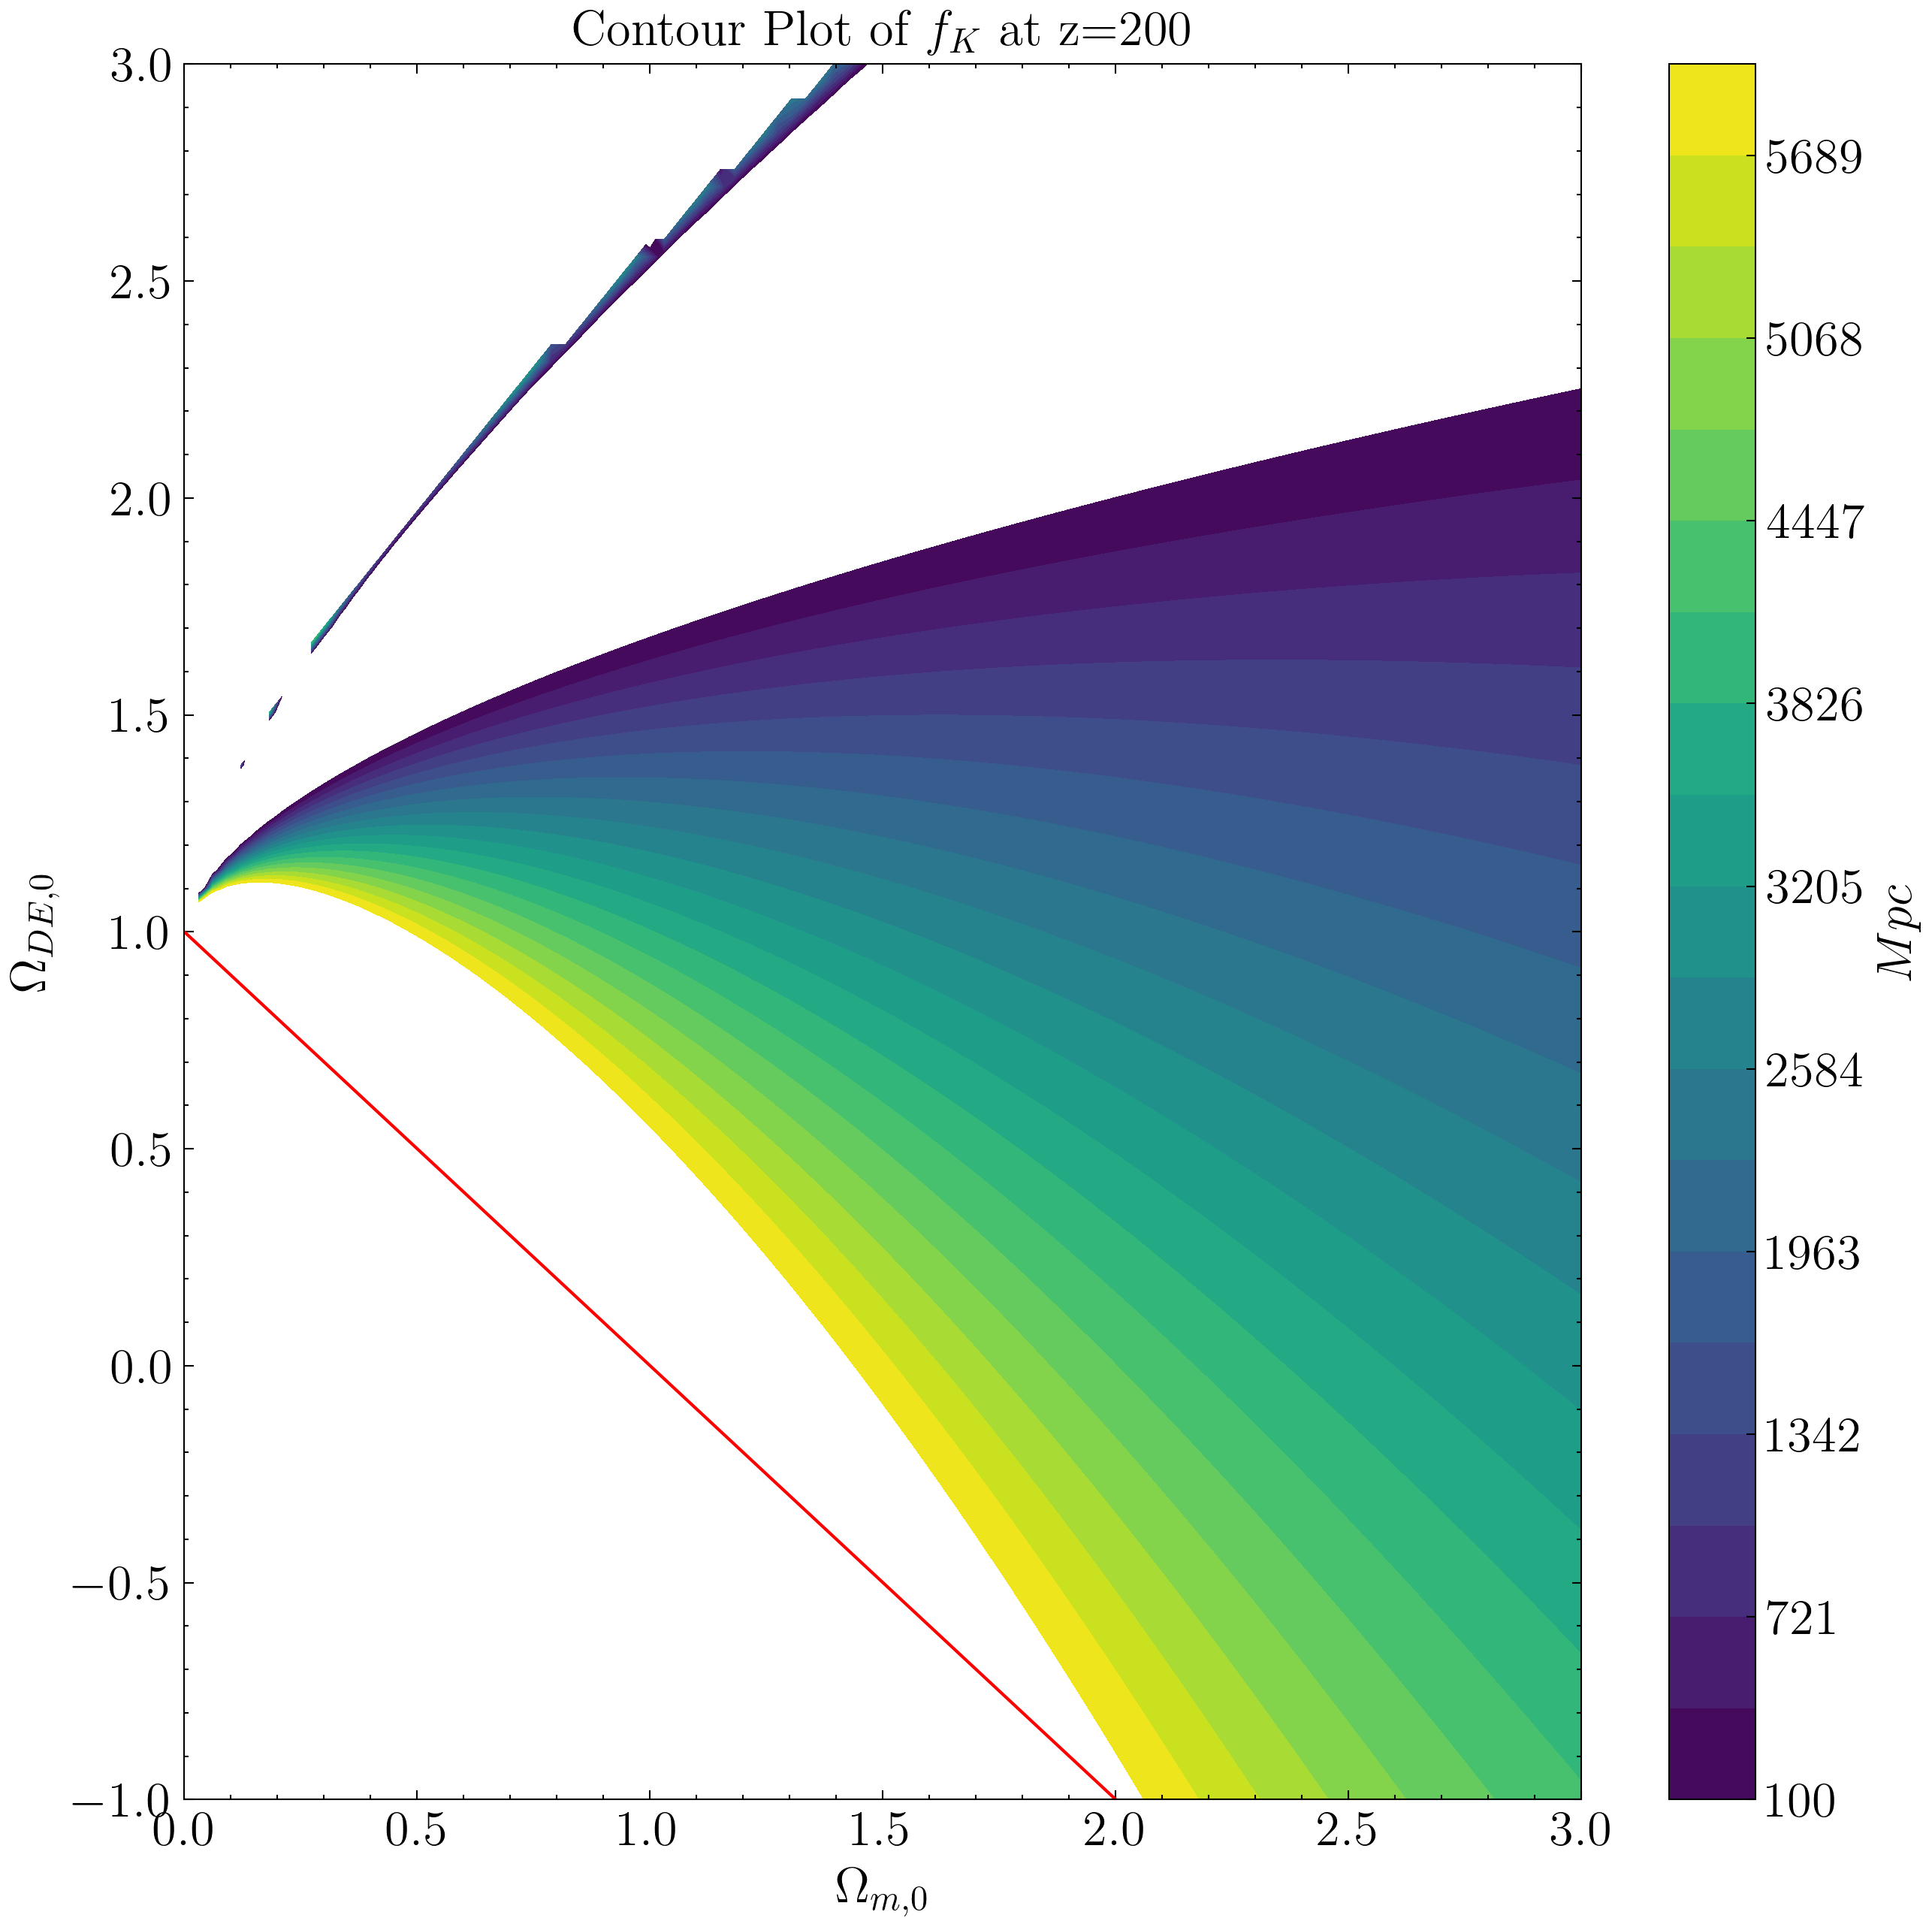

In [14]:
contour_fK(200, lvls=np.linspace(100, 6_000, 20))

/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/3056088390.py:12: RuntimeWarning: invalid value encountered in sqrt
  output = np.sqrt(matter + curvature + dark_energy)
/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/1277488624.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = integrate.quad(integrand, 0, z, limit=70)


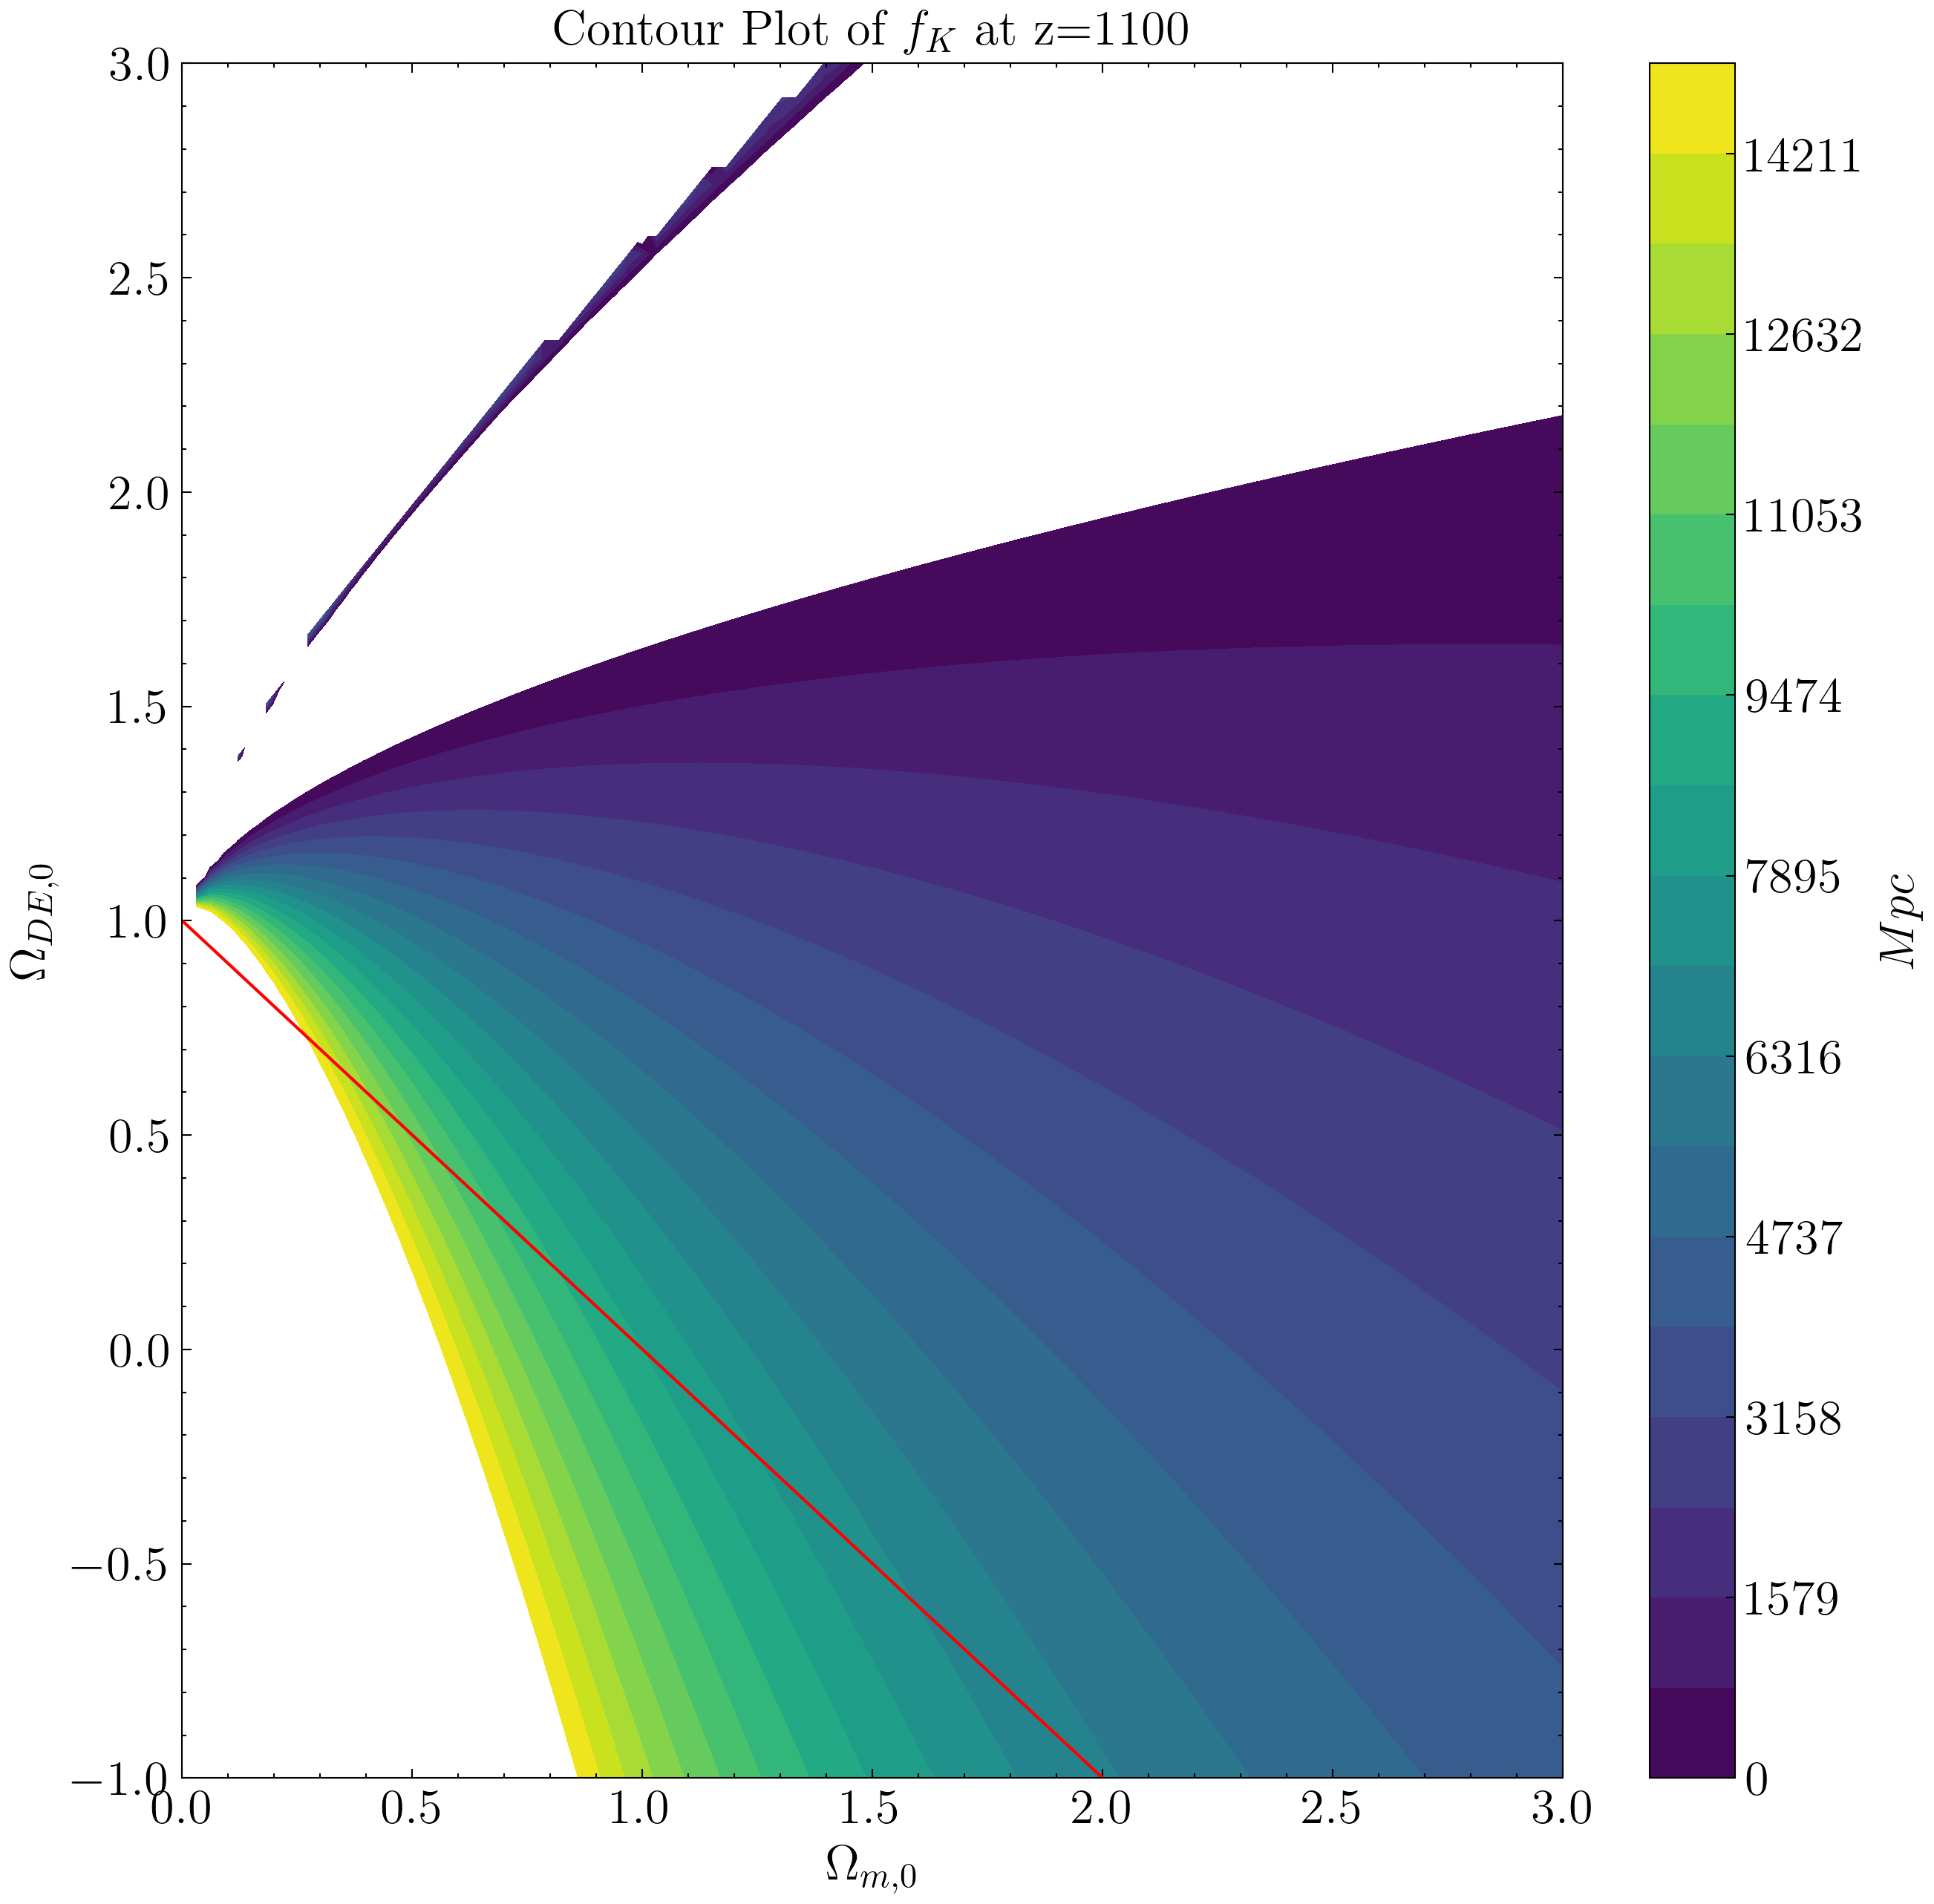

In [15]:
contour_fK(1100, lvls=np.linspace(0, 15_000, 20))

/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/3056088390.py:12: RuntimeWarning: invalid value encountered in sqrt
  output = np.sqrt(matter + curvature + dark_energy)
/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/1277488624.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = integrate.quad(integrand, 0, z, limit=70)


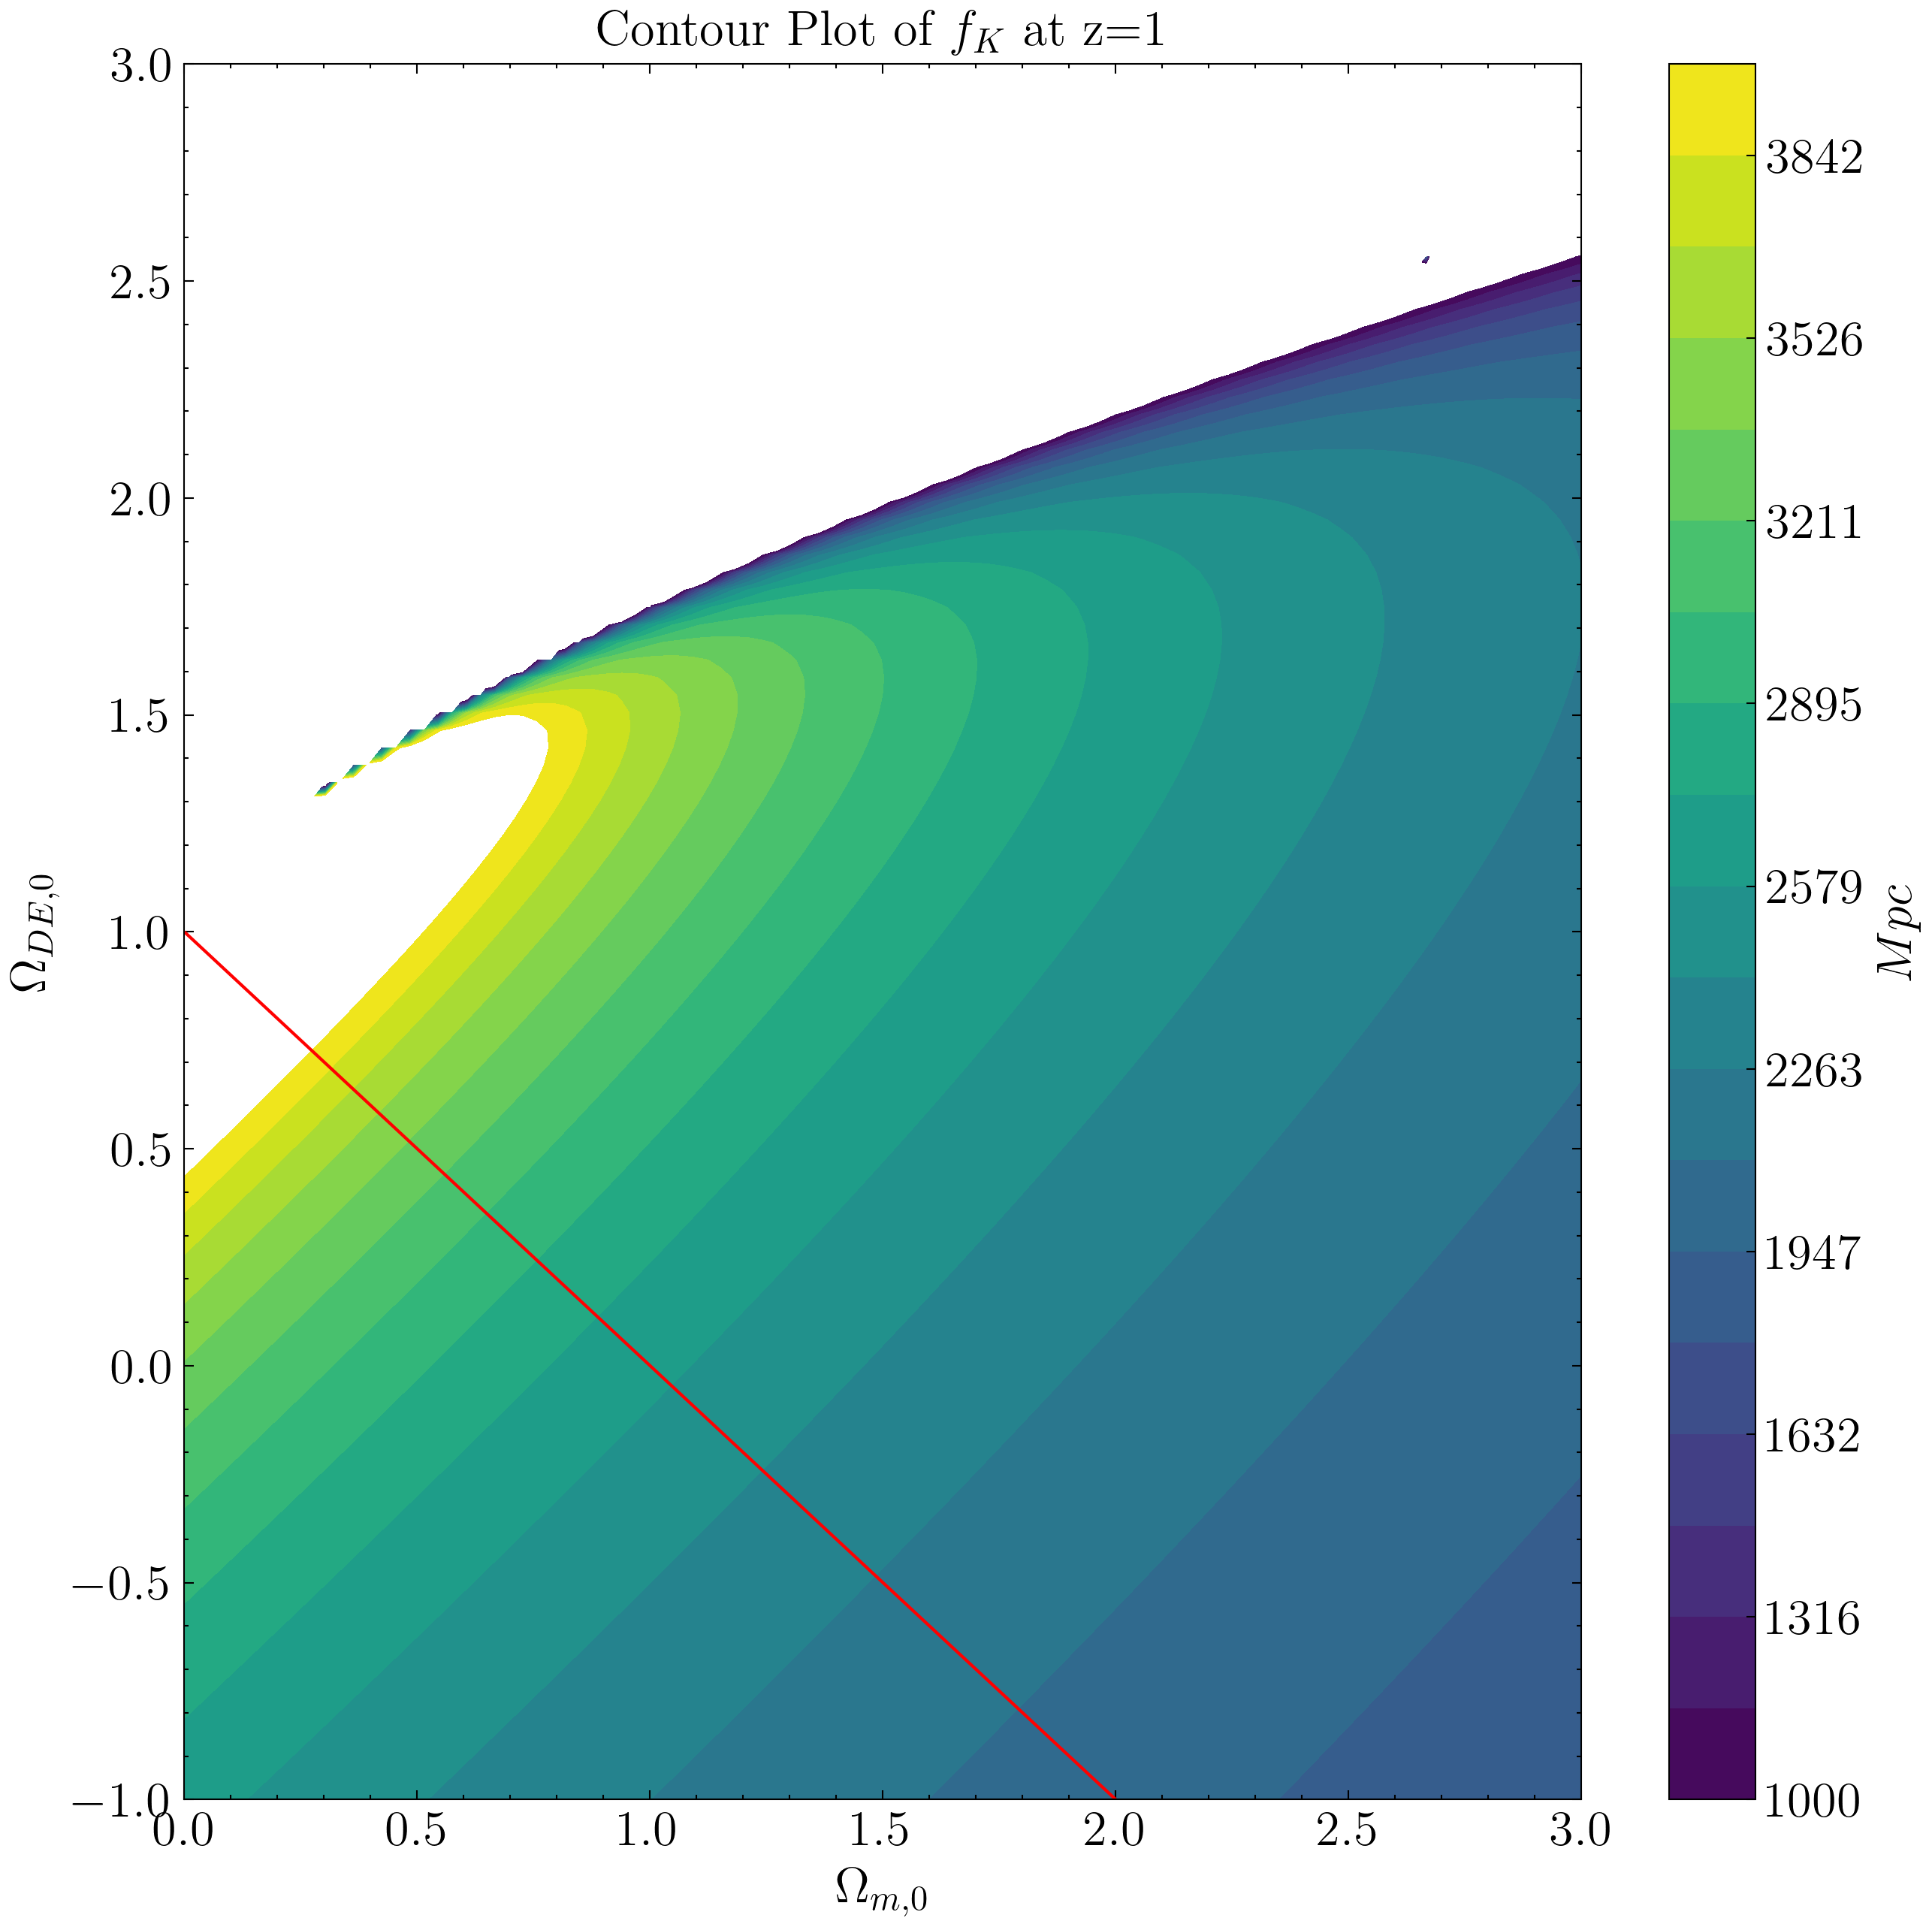

In [16]:
contour_fK(1, lvls=np.linspace(1000, 4000, 20), w0=-2, wa=1)

/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/3056088390.py:12: RuntimeWarning: invalid value encountered in sqrt
  output = np.sqrt(matter + curvature + dark_energy)
/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/1277488624.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = integrate.quad(integrand, 0, z, limit=70)


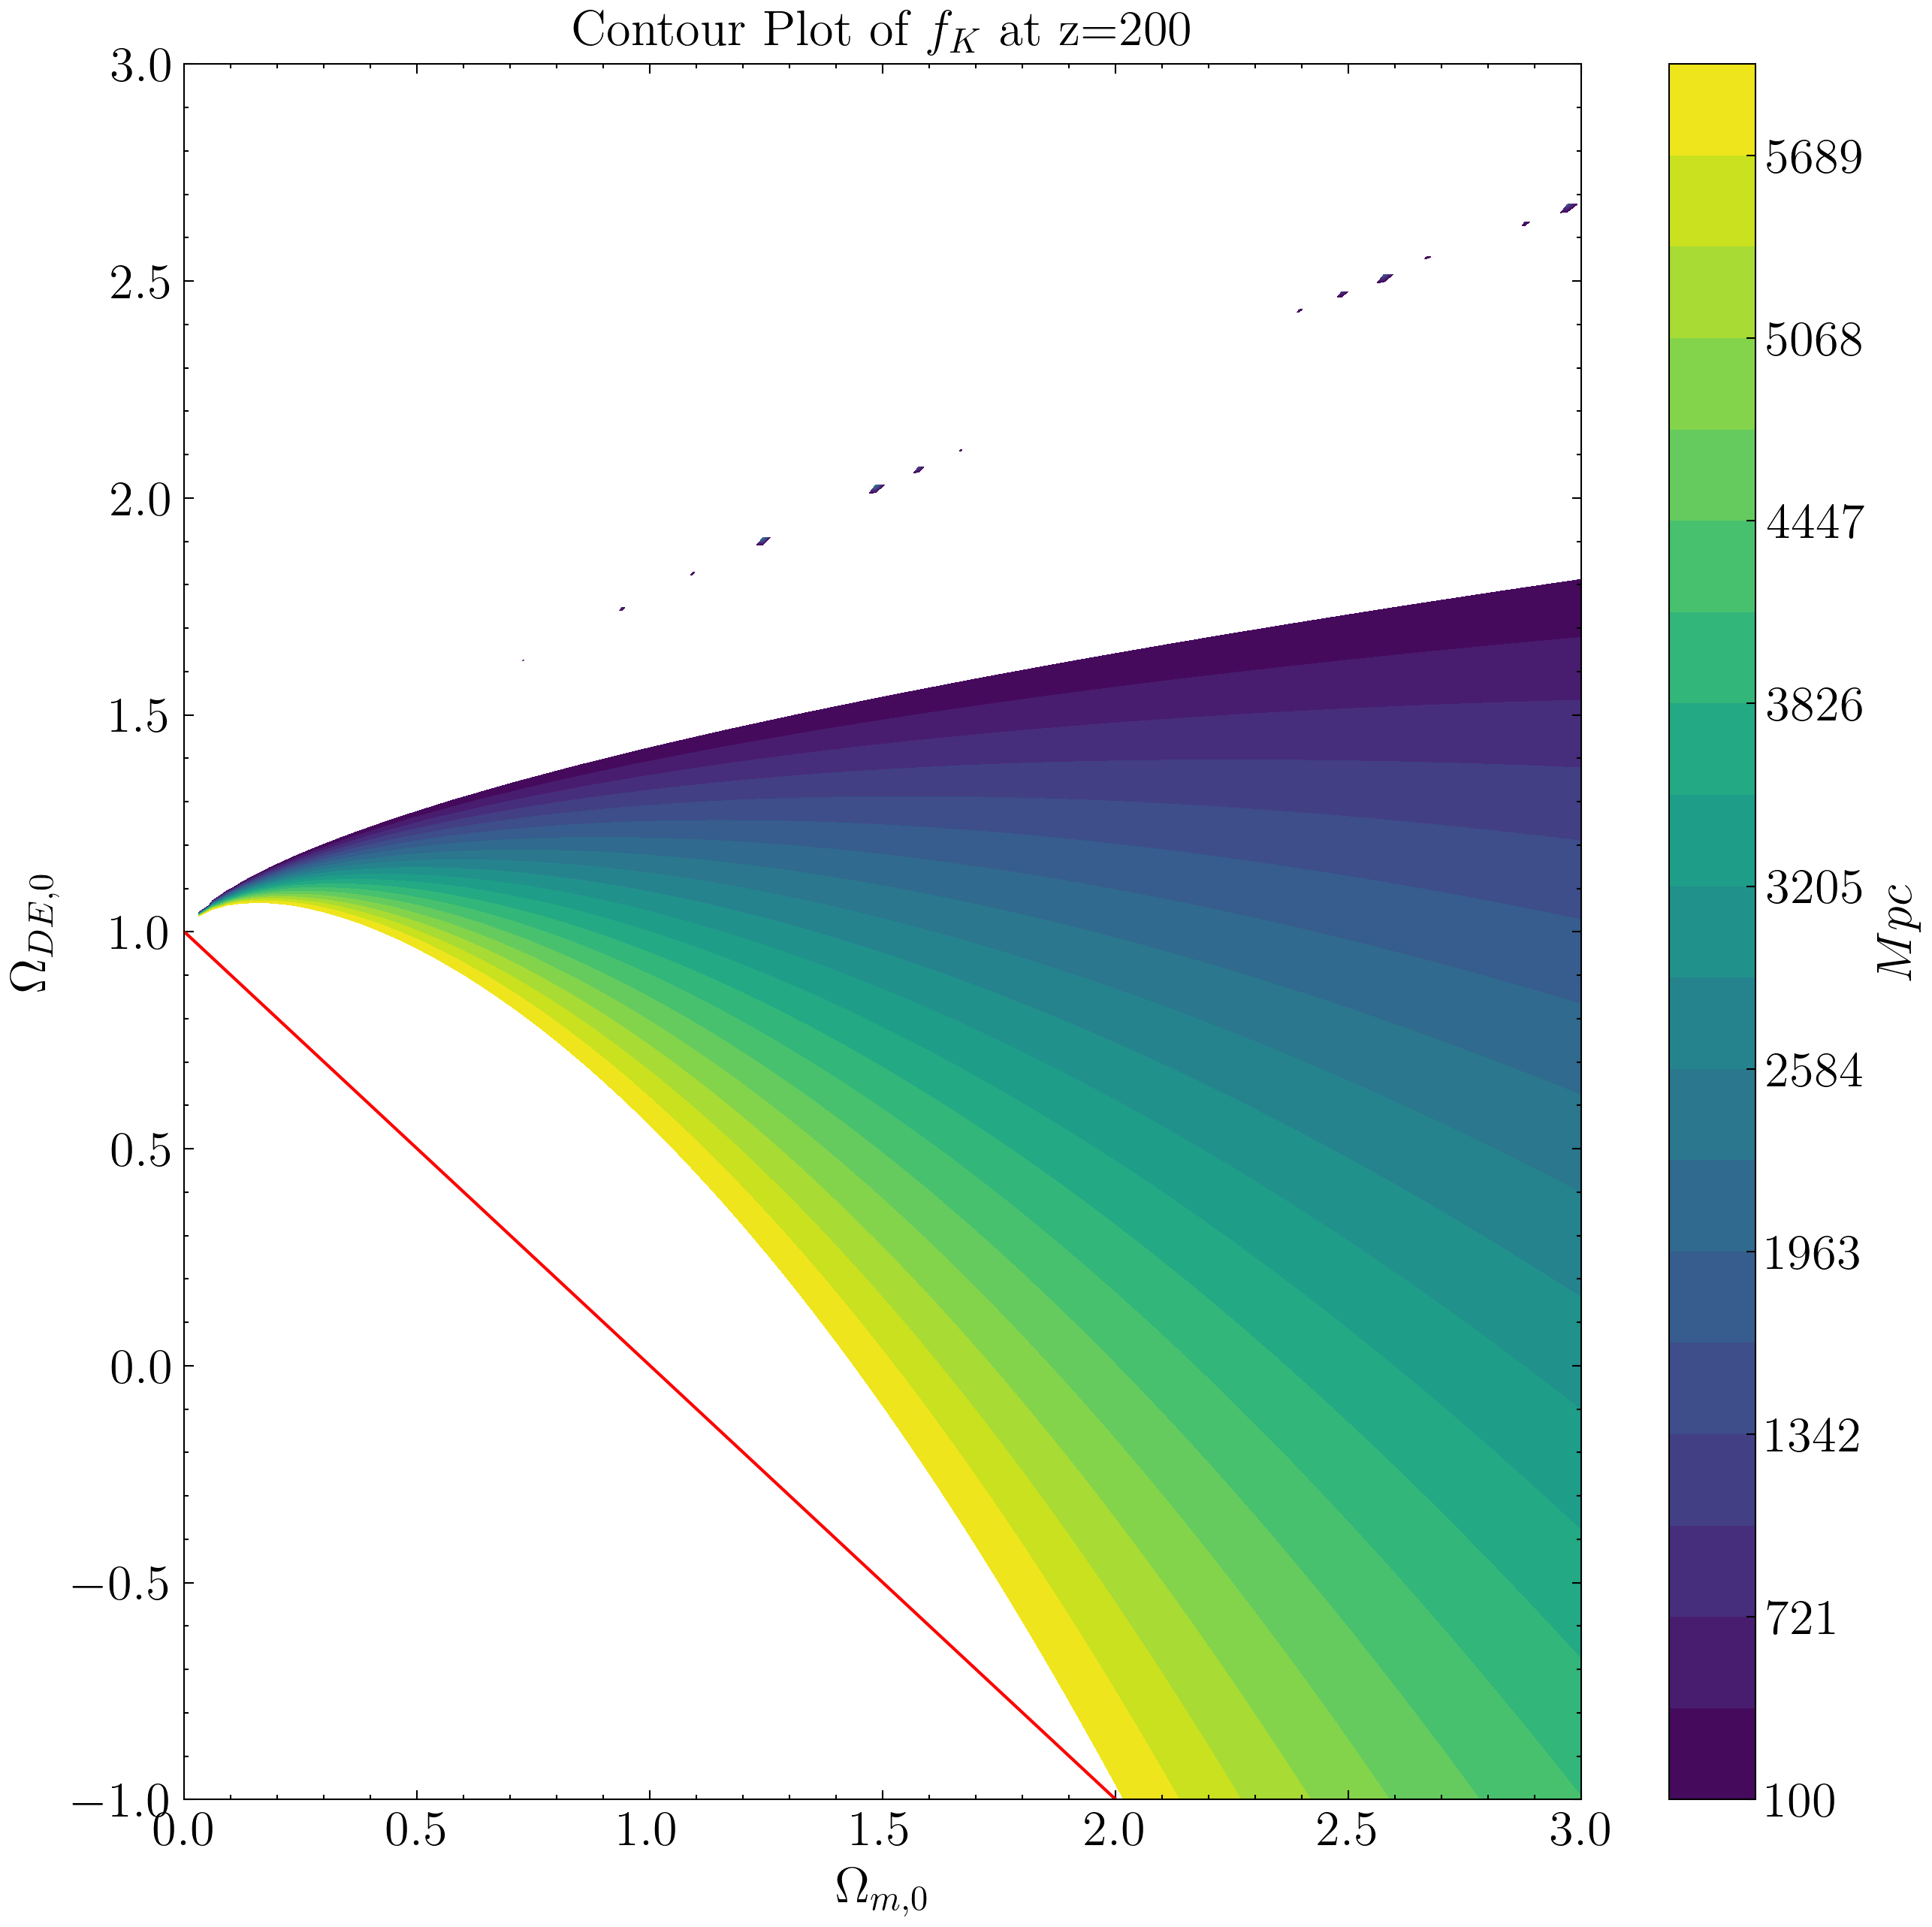

In [17]:
contour_fK(200, lvls=np.linspace(100, 6_000, 20), w0=-2, wa=1)

/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/3056088390.py:12: RuntimeWarning: invalid value encountered in sqrt
  output = np.sqrt(matter + curvature + dark_energy)
/var/folders/5s/qjyr0m0s7md6xl0nnsqwt72h0000gn/T/ipykernel_9154/1277488624.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = integrate.quad(integrand, 0, z, limit=70)


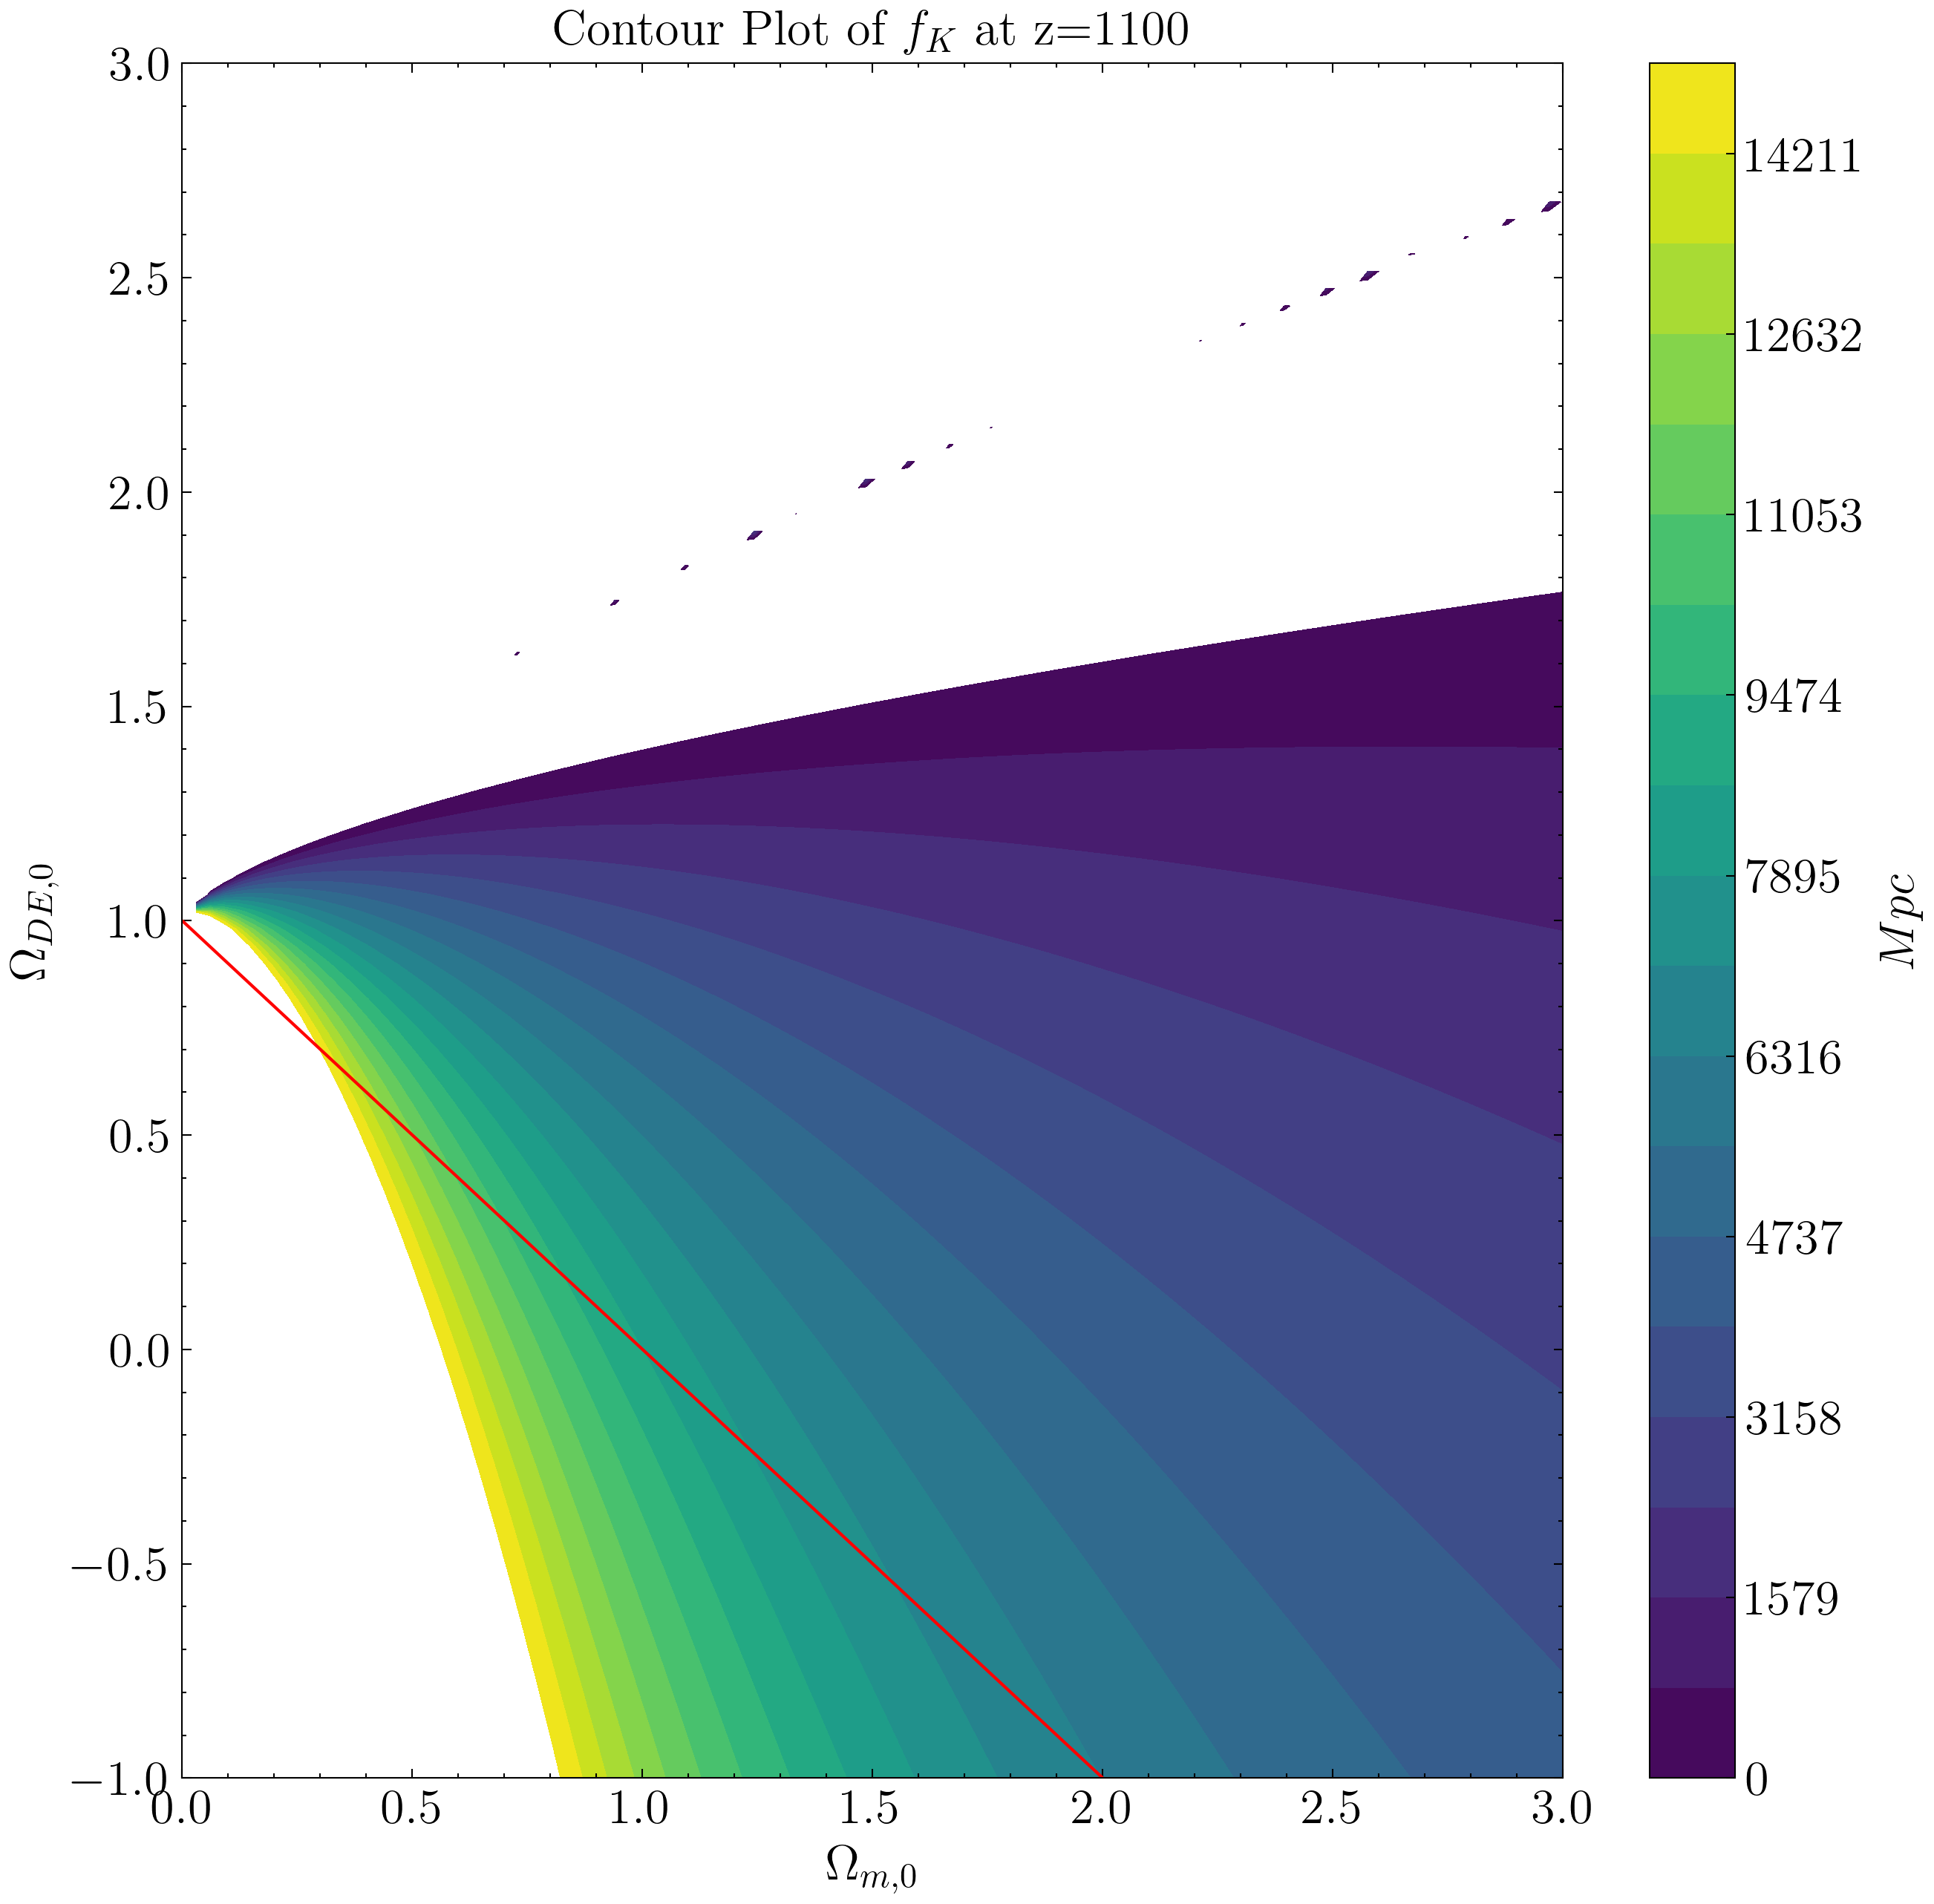

In [18]:
contour_fK(1100, lvls=np.linspace(0, 15_000, 20), w0=-2, wa=1)